In [1]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.fft import fft2, fftshift
import os
import numpy as np
from astropy.io import fits
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.visualization import LogStretch
from scipy.ndimage import gaussian_filter
from matplotlib.colors import Normalize
import matplotlib.cm as cm
import little_things_functions as ltf
import math
import little_things_functions as ltf

# RD 

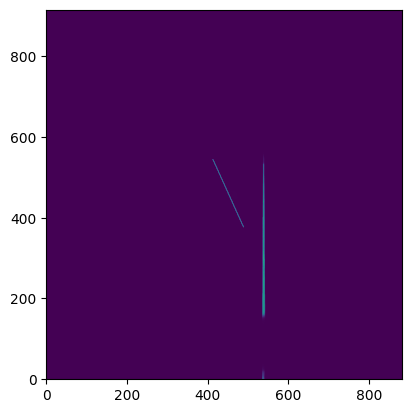

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


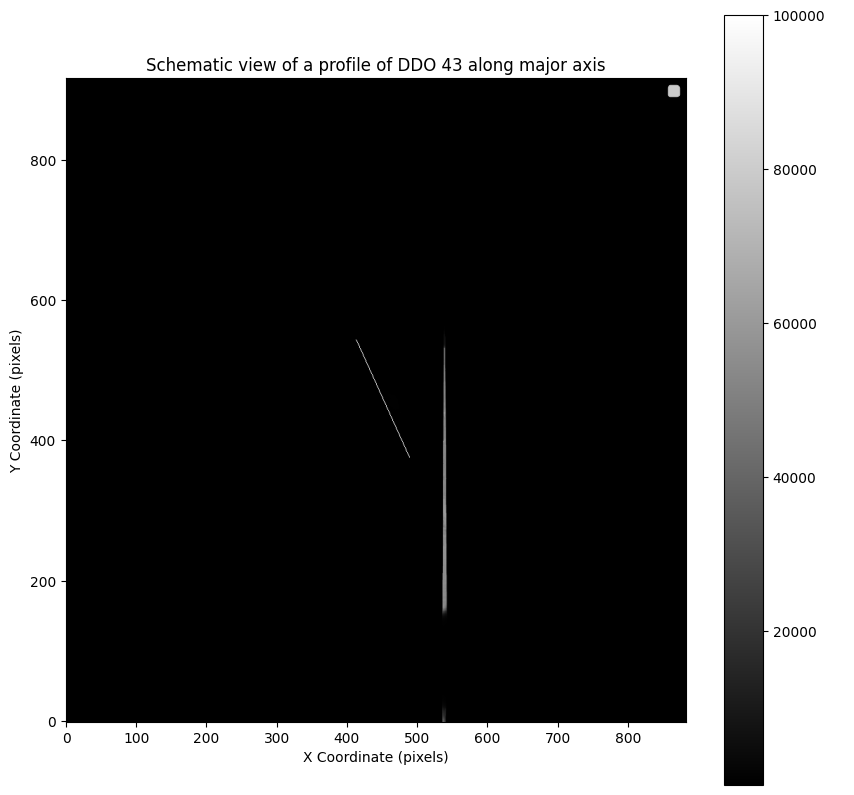

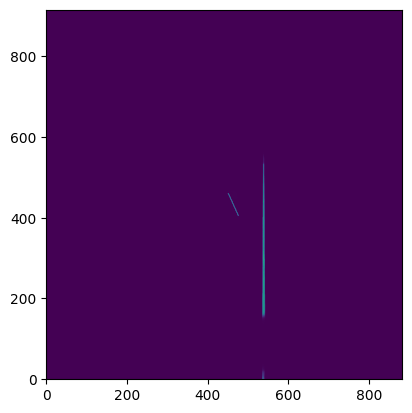

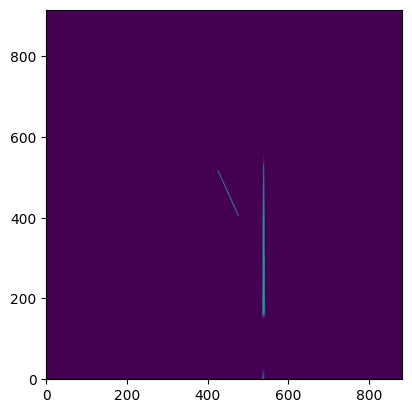

x_ax_left length: 56
x_ax_right length: 56
values_along_line_left length: 56
values_along_line_right length: 56
x_ax combined length: 112
values_along_line combined length: 112


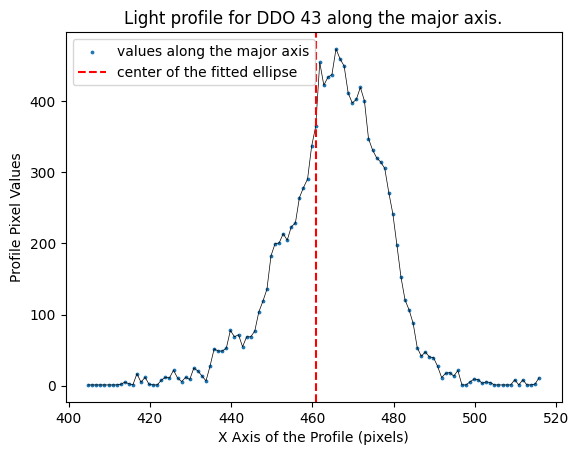

Threshold value: 241.4427059256851
Center of galaxy (Equal Area on both sides of the center line): 465.826


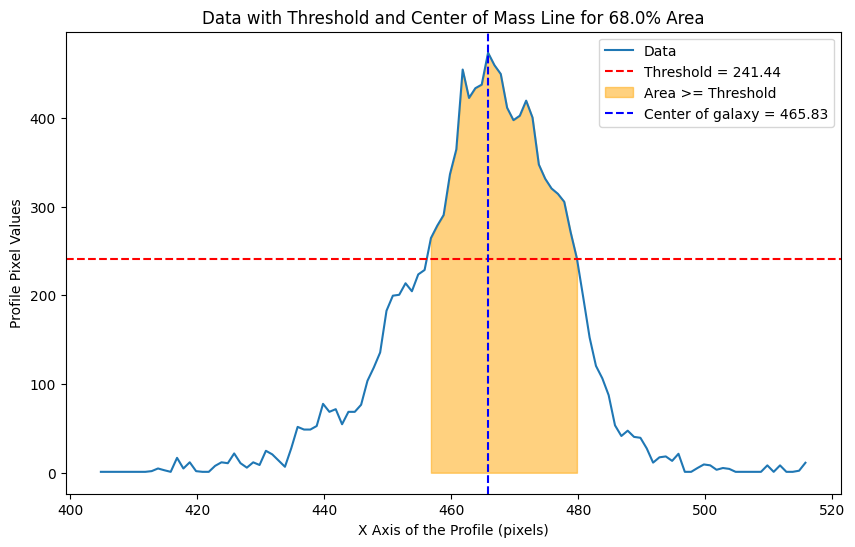

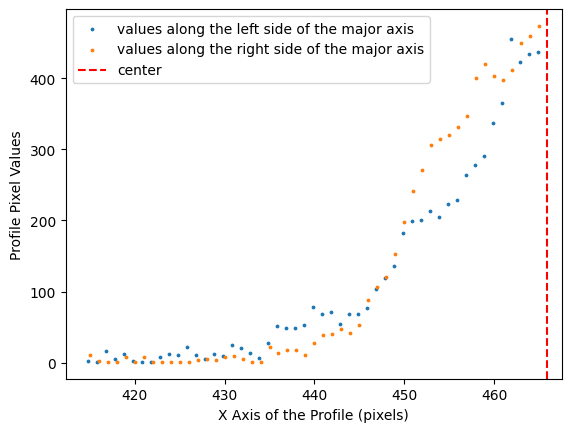

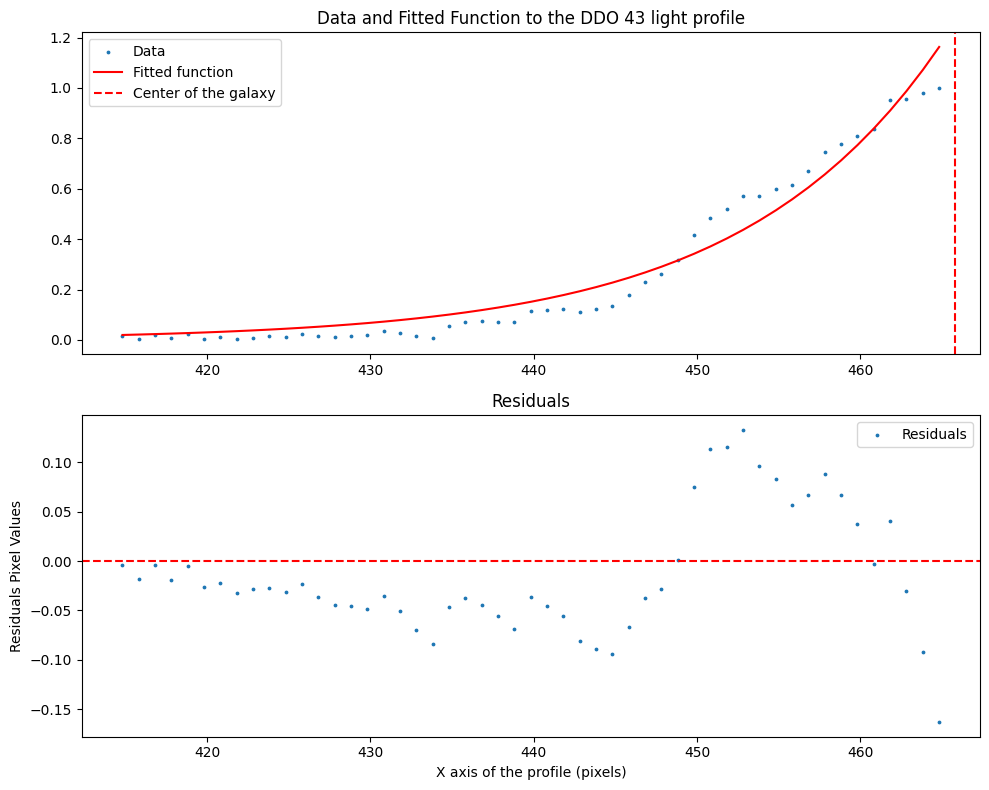

Exponential fit function is exp(b * (x)
RD is 12.2607 pixels
RD for DDO 43 is 0.37073567546757424 kpc
RD for DDO 43 in paper is 0.43 kpc


In [17]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from astropy.visualization import ImageNormalize, LogStretch
import numpy as np
from scipy.optimize import curve_fit

galaxy_name = "DDO 43"
D = 5.5
x_start = 400
y_start = 390
a_half = 28
b_half = 15
theta_deg = 24.334
X_center = 60.826 + x_start
y_center = 63.723 + y_start
visual_43 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43v.fits"))
theta_rad = np.radians(180-theta_deg)
list_of_ellipse_data = [theta_rad , a_half, b_half]
x_ax_left = np.arange(X_center - 3*a_half, X_center)
x_ax_right = np.arange(X_center , X_center + 3*a_half)
x_ax = np.concatenate((x_ax_left, x_ax_right))
def get_line_values(image, x_ax, center_of_galaxy_y, theta_rad):
    m = np.tan(theta_rad)
    values = []
    y_list = []
    for x in x_ax:
        y = int(m * x + center_of_galaxy_y - (m)*(y_center))
        y = int(y)
        x = int(x)
        if 0 <= y < image.shape[0] and 0 <= x < image.shape[1]:
            values.append(image[y, x])
            image[x,y] = 100000
            y_list.append(y)
    plt.imshow(image, origin = 'lower')
    plt.show()
    return values, y_list
get_line_values(visual_43, x_ax, y_center, theta_rad)

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(visual_43, cmap='gray', origin='lower')
cbar = plt.colorbar(im, ax=ax)
cbar.set_label(" ")
plt.title(f"Schematic view of a profile of {galaxy_name} along major axis")
plt.xlabel('X Coordinate (pixels)')
plt.ylabel('Y Coordinate (pixels)')
plt.legend()
plt.show()


DDO_43 = np.array(ltf.open_fits(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43v.fits"))


def RD(image, distance, pixel_scale, list_of_ellipse_data, center_of_galaxy_x, center_of_galaxy_y, galaxy_name, ratio=0.68, initial_guesses=[45, 0.1, 25]):
    theta_rad = np.radians(180-theta_deg)
    
    x_ax_left = np.arange(center_of_galaxy_x - 2*a_half , center_of_galaxy_x)
    x_ax_right = np.arange(center_of_galaxy_x, center_of_galaxy_x + 2*a_half)
    values_along_line_left, y_list_left = get_line_values(image, x_ax_left, center_of_galaxy_y, theta_rad)
    values_along_line_right, y_list_right = get_line_values(image, x_ax_right, center_of_galaxy_y, theta_rad)
    
    y_ax = np.concatenate((y_list_left, y_list_right))
    x_ax = np.concatenate((x_ax_left, x_ax_right))
    values_along_line = np.concatenate((values_along_line_left, values_along_line_right))

    # Add print statements to debug the lengths
    print(f"x_ax_left length: {len(x_ax_left)}")
    print(f"x_ax_right length: {len(x_ax_right)}")
    print(f"values_along_line_left length: {len(values_along_line_left)}")
    print(f"values_along_line_right length: {len(values_along_line_right)}")

    print(f"x_ax combined length: {len(x_ax)}")
    print(f"values_along_line combined length: {len(values_along_line)}")

        
    if len(x_ax) == len(values_along_line):
        plt.scatter(x_ax, values_along_line, s=3, label='values along the major axis')
        plt.plot(x_ax, values_along_line, color="black", linewidth=0.5)
        plt.title(f"Light profile for {galaxy_name} along the major axis.")
        plt.axvline(x=center_of_galaxy_x, color='r', linestyle='--', label='center of the fitted ellipse')
        plt.xlabel("X Axis of the Profile (pixels)")
        plt.ylabel("Profile Pixel Values")
        plt.legend()
        plt.show()
    else:
        print("The lengths of x_ax and values_along_line do not match.")
        print(len(x_ax))
        print(len(values_along_line))
        return
    
    values_along_line = np.array(values_along_line)
    x_ax = np.array(x_ax)
    
    total_area = np.trapz(values_along_line, x=x_ax)
    
    sorted_values = np.sort(values_along_line)[::-1]
    cumulative_area = np.cumsum(sorted_values) * (x_ax[1] - x_ax[0])
    
    threshold_index = np.searchsorted(cumulative_area, ratio * total_area)
    threshold_value = sorted_values[threshold_index]
    
    filtered_values = values_along_line[values_along_line > threshold_value]
    filtered_x_ax = x_ax[values_along_line > threshold_value]
    
    cumulative_intensity = np.cumsum(values_along_line)
    total_intensity = cumulative_intensity[-1]
    
    com_index = np.searchsorted(cumulative_intensity, total_intensity / 2)
    center_of_mass_x = x_ax[com_index]
    center_of_mass_y = y_ax[com_index]
    print(f"Threshold value: {threshold_value}")
    print(f"Center of galaxy (Equal Area on both sides of the center line): {center_of_mass_x}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(x_ax, values_along_line, label='Data')
    plt.axhline(y=threshold_value, color='r', linestyle='--', label=f'Threshold = {threshold_value:.2f}')
    plt.fill_between(x_ax, values_along_line, where=(values_along_line >= threshold_value), color='orange', alpha=0.5, label='Area >= Threshold')
    plt.axvline(x=center_of_mass_x, color='blue', linestyle='--', label=f'Center of galaxy = {center_of_mass_x:.2f}')
    plt.legend()
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.title(f'Data with Threshold and Center of Mass Line for {ratio * 100}% Area')
    plt.show()

    values_along_line_left = values_along_line[:com_index]
    values_along_line_right = values_along_line[com_index:]

    x_ax_left = x_ax[:com_index]
    x_ax_right = x_ax[com_index:]

    if len(x_ax_left) > len(x_ax_right):
        delete = len(x_ax_left) - len(x_ax_right)
        x_ax_left = x_ax_left[delete:]
        values_along_line_left = values_along_line_left[delete:]
    elif len(x_ax_left) < len(x_ax_right):
        delete = len(x_ax_right) - len(x_ax_left)
        x_ax_right = x_ax_right[:-delete]
        values_along_line_right = values_along_line_right[:-delete]

    flipped_x_ax_right = []
    for i in range(len(x_ax_right)):
        x = (2 * center_of_mass_x - x_ax_right[i])
        flipped_x_ax_right.append(int(x))

    flipped_x_ax_right = np.array(flipped_x_ax_right)

    plt.scatter(x_ax_left, values_along_line_left, s=3, label='values along the left side of the major axis')
    plt.scatter(flipped_x_ax_right, values_along_line_right, s=3, label='values along the right side of the major axis')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='center')
    plt.xlabel("X Axis of the Profile (pixels)")
    plt.ylabel("Profile Pixel Values")
    plt.legend()
    plt.show()
    
    x1 = x_ax_left  
    x2 = flipped_x_ax_right
    y1 = values_along_line_left
    y2 = values_along_line_right[::-1]
    mean_y = (y1 + y2)/2
    bkg_values = np.mean([np.mean(mean_y[0:10]), np.mean(mean_y[-10:])])
    #mean_y = mean_y - bkg_values
    mean_y_normal = (mean_y / np.max(mean_y)) 
    def exponential_func(x, b, x0):
        return np.exp(b * (x-x0))

    popt, pcov = curve_fit(exponential_func, x_ax_left, mean_y_normal, p0=initial_guesses)

    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    plt.scatter(x_ax_left, mean_y_normal, s=3, label='Data')
    plt.plot(x_ax_left, exponential_func(x_ax_left, *popt), label='Fitted function', color='red')
    plt.axvline(x=center_of_mass_x, color='r', linestyle='--', label='Center of the galaxy')
    plt.legend()
    plt.title(f'Data and Fitted Function to the {galaxy_name} light profile')
    residuals = mean_y_normal - exponential_func(x_ax_left, *popt) 
    plt.subplot(2, 1, 2) 
    plt.scatter(x_ax_left, residuals, s=3, label='Residuals') 
    plt.axhline(0, color='red', linestyle='--') 
    plt.legend() 
    plt.xlabel('X axis of the profile (pixels)') 
    plt.ylabel('Residuals Pixel Values') 
    plt.title('Residuals') 
    plt.tight_layout() 
    plt.show()
    
    perr = np.sqrt(np.diag(pcov))
    print("Exponential fit function is exp(b * (x)")
    print(f"RD is {1/popt[0]:.4f} pixels")
    
    R_D_pixels = 1/popt[0]
    R_D_arcsec = R_D_pixels * pixel_scale
    RD_value = ((distance * R_D_arcsec) / 206265)*1000
    print(f"RD for {galaxy_name} is {RD_value} kpc")
    print(f"RD for {galaxy_name} in paper is 0.43 kpc")
    return R_D_pixels, RD_value, x_ax_left, mean_y

list_of_ellipse_data = [theta_rad , a_half, b_half]
RD_pixels , RD_kpc, x_values, y_values = RD(DDO_43, D, 1.134, list_of_ellipse_data, X_center, y_center, galaxy_name, initial_guesses=[0.006, 25])

# Boot Strapping

sigma is 4.689429429907036
RD values: [0.36974387903842676, 0.37030192960166836, 0.3737688746670171, 0.37098577127805843, 0.3708941193173195, 0.37110607430670767, 0.3692464994946767, 0.37038303029251873, 0.3747901909470809, 0.36724864281942987, 0.37169753660064675, 0.37148081527462296, 0.373073938621868, 0.3692394194925281, 0.36817769694836217, 0.3680053129261344, 0.3710413056452628, 0.3705739505416801, 0.3706218181593496, 0.3746122210689592, 0.37168707040658233, 0.37018240717690437, 0.3690621492898728, 0.37198164340430045, 0.3721163807451596, 0.3679887516854613, 0.3711344046384595, 0.372962906747259, 0.368155255168317, 0.37150278922854346, 0.3736959299068123, 0.3731604334742389, 0.3686472824220508, 0.37017248205361347, 0.36910810714757414, 0.37070357189842984, 0.37192734959627183, 0.36918398877116204, 0.369871315501882, 0.3698653761237092, 0.3713139620370444, 0.3716199823111449, 0.3705714220138118, 0.37300714019338543, 0.3710924212878972, 0.3747990358666845, 0.3693107040988563, 0.3696

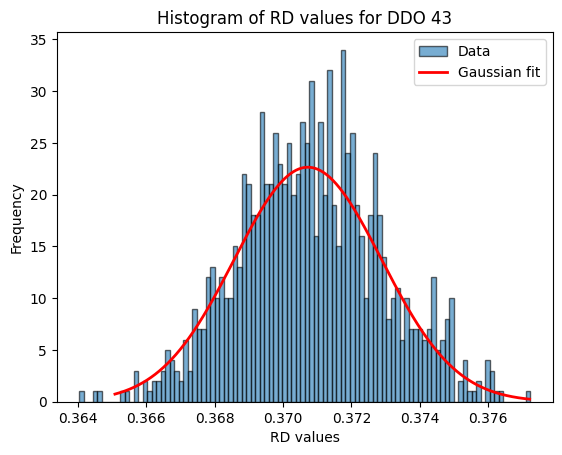

In [34]:
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import numpy as np

# Define the exponential function
def exponential_func(x, b, x0):
        return np.exp(b * (x-x0))

# Assume DDO_101 and y_values are defined
sigma = np.std(DDO_43[: , 0:300])
print("sigma is" ,sigma)

# Number of iterations
n = 1000

# Lists to store the fitted parameters
b_list = []
x0_list = []
RD_list = []

# Loop for bootstrapping
for i in range(n):
    # Generate unique random noise for each data point from the normal distribution
    noise = np.random.normal(0, sigma, size=len(y_values))
    # Add unique noise to each data point in y_values
    y_noisy = y_values + noise
    # Fit the exponential function to the noisy data
    popt, pcov = curve_fit(exponential_func, x_values, y_noisy, p0=([0.006, 25]))
    
    # Append the parameters to the respective lists
    
    b_list.append(popt[0])
    RD_pixels = 1/popt[0]
    RD_arcsec = RD_pixels * 1.134
    RD_value = ((D * RD_arcsec) / 206265)*1000
    RD_list.append(RD_value)
    
    x0_list.append(popt[1])



print(f"RD values: {RD_list}")
def gaussian(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Generate histogram data
counts, bin_edges = np.histogram(RD_list, bins=100)

# Calculate bin centers
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# Initial guess for the parameters (A, mu, sigma)
initial_guess = [max(counts), np.mean(RD_list), np.std(RD_list)]

# Fit the Gaussian function to the histogram data
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=initial_guess)


# Print the fitted parameters
print(f"Fitted parameters: mean={popt[1]}, sigma={popt[2]}")

rd_value = f"{popt[1]:.3f}" 
rd_error = f"{popt[2]:.3f}"  

print(f"RD for {galaxy_name} is {rd_value} +/- {rd_error}")

import os


# Correct the folder name path
output_folder = r"C:\Users\AYSAN\Desktop\project\Galaxy\RD_Histogram"
output_filename = f"{galaxy_name}_RD_Histogram.png"
output_path = os.path.join(output_folder, output_filename)

# Ensure folder exists
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Plotting and saving the histogram
plt.hist(RD_list, bins=100, edgecolor='k', alpha=0.6, label='Data')
plt.plot(x_fit, y_fit, color='red', linewidth=2, label='Gaussian fit')
plt.xlabel('RD values')
plt.ylabel('Frequency')
plt.title(f'Histogram of RD values for {galaxy_name}')
plt.legend()

# Save the plot
plt.savefig(output_path)





